In [1]:
import pandas as pd
import numpy as np

# to draw plot
import altair as alt
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# For data preparing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

# For Model Building 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# For evaluation
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score


In [6]:
# Read file
raw_data=pd.read_csv(r"milknew.csv")
raw_data.rename(columns=lambda x: x.strip(),inplace=True)  #remove space in column names 
column = raw_data.columns
## Explore the data
print(column,"\n")
print(raw_data.info(),"\n")
print(raw_data.describe(),"\n")

# Divided predictors and response variable
raw_y=raw_data["Grade"].copy() #Avoid modify the origin data set
raw_y.replace({'low':0,'medium':1,'high':2},inplace=True) # factorize the response variable
raw_x=raw_data.drop(["Grade"],axis=1) # Keep all predictors

Index(['pH', 'Temprature', 'Taste', 'Odor', 'Fat', 'Turbidity', 'Colour',
       'Grade'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB
None 

                pH   Temprature        Taste         Odor          Fat  \
count  1059.000000  1059.000000  1059.000000  1059.000000  1059.000000   
mean      6.630123    44.226629     0.546742     0.432483     0.671388   
std       1.399679    10.098364     0.498046     0.495655     0.469930   
min

In [7]:
# Check missing value
raw_data.isna().any() 

pH            False
Temprature    False
Taste         False
Odor          False
Fat           False
Turbidity     False
Colour        False
Grade         False
dtype: bool

In [8]:
# divide numerical and categorical variables
## column names of both variables
category=["Taste","Odor","Fat","Turbidity"] 
numeric=raw_x.columns[~raw_x.columns.isin(category)].tolist() 
## sub-dataset of both variables
numeric_df=raw_data.loc[:,~raw_data.columns.isin(category)]
category_df=raw_data.loc[:,category+["Grade"]]

In [12]:
# See the distribution
boxplot= alt.Chart(numeric_df).mark_boxplot().encode(y=alt.Y("Grade",sort=["low","medium","high"]),x=alt.X(alt.repeat("column"),type="quantitative",scale=alt.Scale(zero=False),axis=alt.Axis(tickCount=4)),color=alt.Color("Grade",legend=None)).properties(width=100,height=70).repeat(column=numeric)
barplot= alt.Chart(category_df).mark_bar().encode(y=alt.Y("count()"),x=alt.X(alt.repeat("column"),scale=alt.Scale(zero=False)),xOffset=alt.Color("Grade:N",sort=["low","medium","high"]),color=alt.Color("Grade:N")).properties(width=70,height=100).repeat(column=category)

In [13]:
boxplot

alt.RepeatChart(...)

In [14]:
barplot

alt.RepeatChart(...)

In [15]:
# split the data
x_train,x_test,y_train,y_test=train_test_split(raw_x,raw_y,test_size=0.2,random_state=0)

In [33]:
# Standardization
miniscalar=MinMaxScaler()
miniscalar.fit(x_train)
x_train=miniscalar.transform(x_train)
x_test=miniscalar.transform(x_test)

# Plot the distribution
test_plot=pd.DataFrame(x_test,columns=raw_x.columns.tolist()) # x_test dataframe after normalization
test_plot=test_plot.reset_index(drop=True) # make it ease to concate with y
print(test_plot,"\n")
y_plot=y_test.reset_index(drop=True) # make it ease to concate with x
y_plot=y_plot.map({0:'low',1:'medium',2:'high'}) # relable for visualization
print(y_plot)
normalize_data=pd.concat([test_plot,y_plot],axis=1)
print(normalize_data)

           pH  Temprature  Taste  Odor  Fat  Turbidity    Colour
0    0.553846    0.053571    1.0   1.0  1.0        1.0  1.000000
1    0.923077    0.160714    1.0   0.0  1.0        1.0  0.666667
2    0.584615    0.196429    0.0   0.0  0.0        1.0  1.000000
3    0.400000    0.285714    0.0   1.0  1.0        1.0  1.000000
4    0.584615    0.196429    1.0   1.0  1.0        1.0  0.333333
..        ...         ...    ...   ...  ...        ...       ...
207  0.584615    0.125000    0.0   0.0  1.0        0.0  1.000000
208  0.584615    0.125000    0.0   0.0  1.0        0.0  1.000000
209  0.384615    0.196429    1.0   0.0  1.0        1.0  0.666667
210  0.584615    0.196429    1.0   1.0  1.0        1.0  0.333333
211  0.584615    0.196429    0.0   0.0  0.0        1.0  1.000000

[212 rows x 7 columns] 

0        high
1         low
2      medium
3         low
4        high
        ...  
207    medium
208    medium
209       low
210      high
211    medium
Name: Grade, Length: 212, dtype: object


In [34]:
ph_plot = alt.Chart(normalize_data).transform_density("pH", as_=["pH", "density"], groupby=["Grade"],extent=[0, 1] ).mark_area(opacity=0.5).encode(
    x=alt.X("pH:Q"),
    y="density:Q",
    color="Grade:N"
).properties(height=100,width=100)
tem_plot = alt.Chart(normalize_data).transform_density("Temprature", as_=["Temprature", "density"], groupby=["Grade"],extent=[0, 1] ).mark_area(opacity=0.5).encode(
    x=alt.X("Temprature:Q"),
    y="density:Q",
    color=alt.Color("Grade:N")
).properties(height=100,width=100)
col_plot = alt.Chart(normalize_data).transform_density("Colour", as_=["Colour", "density"], groupby=["Grade"],extent=[0, 1] ).mark_area(opacity=0.5).encode(
    x=alt.X("Colour:Q"),
    y="density:Q",
    color=alt.Color("Grade:N")
).properties(height=100,width=100)
ph_plot | tem_plot | col_plot

alt.HConcatChart(...)

## Logistic

In [35]:
#Logistic
model_logisctic=LogisticRegression(max_iter=1000,multi_class='ovr')
model_logisctic.fit(x_train,y_train)
y_pred_train=model_logisctic.predict(x_train)
y_pred_test=model_logisctic.predict(x_test)
cm_trian=confusion_matrix(y_train,y_pred_train)
cm_test=confusion_matrix(y_test,y_pred_test)
print("The accurancy of train data is {}".format(accuracy_score(y_train,y_pred_train)))
print("The accurancy of test data is {}".format(accuracy_score(y_test,y_pred_test)))

The accurancy of train data is 0.7992916174734357
The accurancy of test data is 0.7358490566037735


In [36]:
print(cross_val_score(model_logisctic,x_train,y_train).mean())

0.7544309084580578


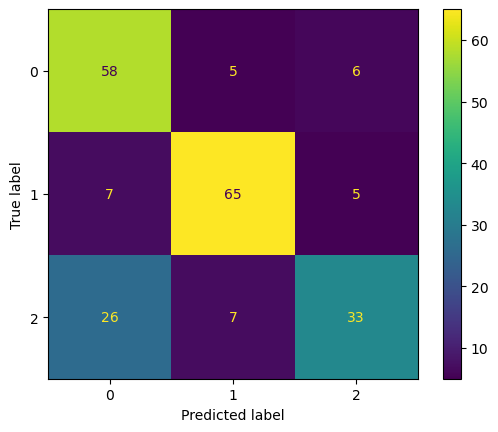

In [40]:
cmp=ConfusionMatrixDisplay(cm_test)
cmp.plot()

# LDA

In [41]:
#LDA
model_LDA=LinearDiscriminantAnalysis()
model_LDA.fit(x_train,y_train)
y_pred_train=model_LDA.predict(x_train)
y_pred_test=model_LDA.predict(x_test)
cm_trian=confusion_matrix(y_train,y_pred_train)
cm_test=confusion_matrix(y_test,y_pred_test)
print("The accurancy of train data is {}".format(accuracy_score(y_train,y_pred_train)))
print("The accurancy of test data is {}".format(accuracy_score(y_test,y_pred_test)))
print(cross_val_score(model_LDA,x_train,y_train).mean())

The accurancy of train data is 0.7272727272727273
The accurancy of test data is 0.6886792452830188
0.741447963800905


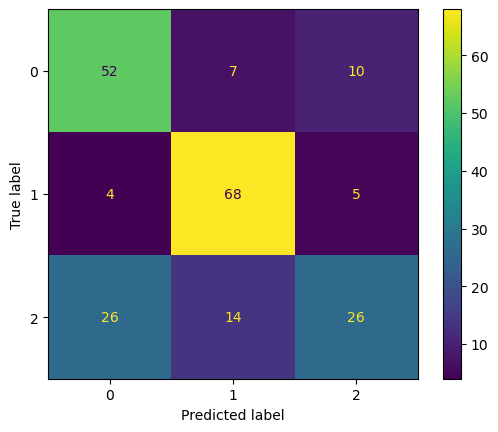

In [43]:
cmp=ConfusionMatrixDisplay(cm_test)
cmp.plot()

# QDA

In [145]:
#QDA
model_QDA=QuadraticDiscriminantAnalysis()
model_QDA.fit(x_train,y_train)
y_pred_train=model_QDA.predict(x_train)
y_pred_test=model_QDA.predict(x_test)
cm_trian=confusion_matrix(y_train,y_pred_train)
cm_test=confusion_matrix(y_test,y_pred_test)
print("The accurancy of train data is {}".format(accuracy_score(y_train,y_pred_train)))
print("The accurancy of test data is {}".format(accuracy_score(y_test,y_pred_test)))
print(cross_val_score(model_QDA,x_train,y_train).mean())

The accurancy of train data is 0.8476977567886659
The accurancy of test data is 0.8066037735849056
0.8181691611555865


D:\ANACONDA\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\ANACONDA\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\ANACONDA\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\ANACONDA\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\ANACONDA\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\ANACONDA\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


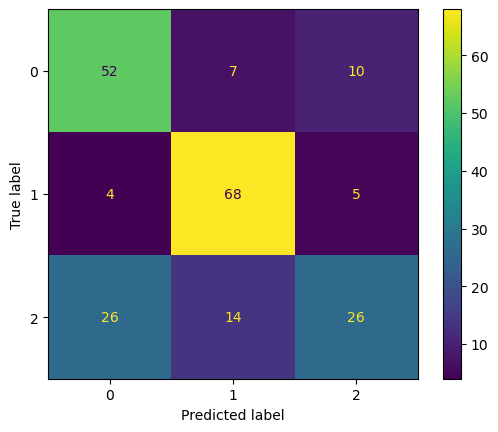

In [44]:
cmp=ConfusionMatrixDisplay(cm_test)
cmp.plot()

# KNN

In [47]:
#KNN
## Build Model
model_KNN=KNeighborsClassifier() # default is 5
model_KNN.fit(x_train,y_train)
y_pred_train=model_KNN.predict(x_train)
y_pred_test=model_KNN.predict(x_test)
print("The accurancy of train data is {}".format(accuracy_score(y_train,y_pred_train)))
print("The accurancy of test data is {}".format(accuracy_score(y_test,y_pred_test)))
print(cross_val_score(model_KNN,x_train,y_train).mean())

The accurancy of train data is 0.9976387249114522
The accurancy of test data is 0.9858490566037735
0.9893839192481726


In [48]:
## Search for parameters
param_grid = {
    'n_neighbors': np.arange(1, 16)
}
Grf=GridSearchCV(model_KNN,param_grid,cv=10)
Grf.fit(x_train,y_train)
print(Grf.best_estimator_,Grf.best_params_)

KNeighborsClassifier(n_neighbors=1) {'n_neighbors': 1}


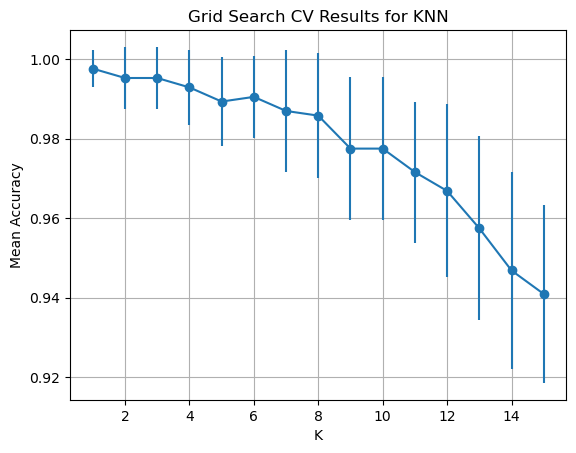

In [51]:
## Display tuning plot
mean_scores=Grf.cv_results_['mean_test_score']
std_scores=Grf.cv_results_['std_test_score']
k_values=np.arange(1, 16)
plt.errorbar(k_values, mean_scores, yerr=std_scores, marker='o', linestyle='-')
plt.title("Grid Search CV Results for KNN")
plt.xlabel("K")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.show()

The accurancy of train data is 1.0
The accurancy of test data is 0.9952830188679245
0.997640097459102


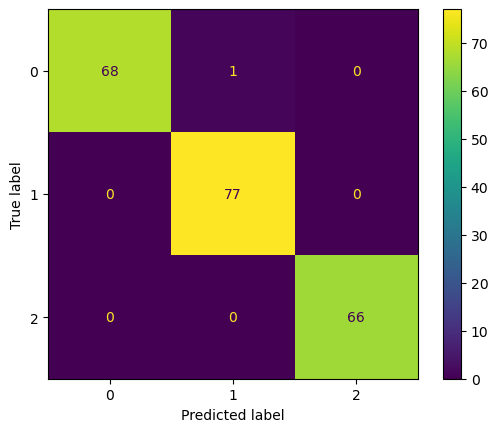

In [54]:
## Try best parameters
model_KNN=KNeighborsClassifier(n_neighbors=1)
model_KNN.fit(x_train,y_train)
y_pred_train=model_KNN.predict(x_train)
y_pred_test=model_KNN.predict(x_test)
cm_trian=confusion_matrix(y_train,y_pred_train)
cm_test=confusion_matrix(y_test,y_pred_test)
print("The accurancy of train data is {}".format(accuracy_score(y_train,y_pred_train)))
print("The accurancy of test data is {}".format(accuracy_score(y_test,y_pred_test)))
print(cross_val_score(model_KNN,x_train,y_train).mean())
cmp=ConfusionMatrixDisplay(cm_test)
cmp.plot()

# TREE

In [52]:
#TREE
## Build model
model_TREE=DecisionTreeClassifier() #by default, no pruning will be performed
model_TREE.fit(x_train,y_train)
y_pred_train=model_TREE.predict(x_train)
y_pred_test=model_TREE.predict(x_test)
cm_trian=confusion_matrix(y_train,y_pred_train)
cm_test=confusion_matrix(y_test,y_pred_test)
print("The accurancy of train data is {}".format(accuracy_score(y_train,y_pred_train)))
print("The accurancy of test data is {}".format(accuracy_score(y_test,y_pred_test)))
print(cross_val_score(model_TREE,x_train,y_train).mean())

The accurancy of train data is 1.0
The accurancy of test data is 0.9905660377358491
0.9940898016011138


In [53]:
## Find best parameter
param_grid = {
    'ccp_alpha': np.linspace(0, 0.05, 50)
}
Grf=GridSearchCV(model_TREE,param_grid,cv=10)
Grf.fit(x_train,y_train)
print(Grf.best_estimator_,Grf.best_params_)

DecisionTreeClassifier() {'ccp_alpha': 0.0}


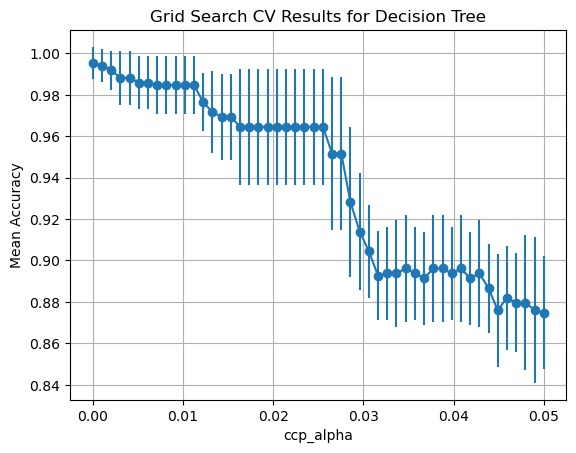

In [55]:
## Tuning plot
mean_scores=Grf.cv_results_['mean_test_score']
std_scores=Grf.cv_results_['std_test_score']
ccp_alpha=np.linspace(0, 0.05, 50)
plt.errorbar(ccp_alpha, mean_scores, yerr=std_scores, marker='o', linestyle='-')
plt.title('Grid Search CV Results for Decision Tree')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean Accuracy')
plt.grid(True)

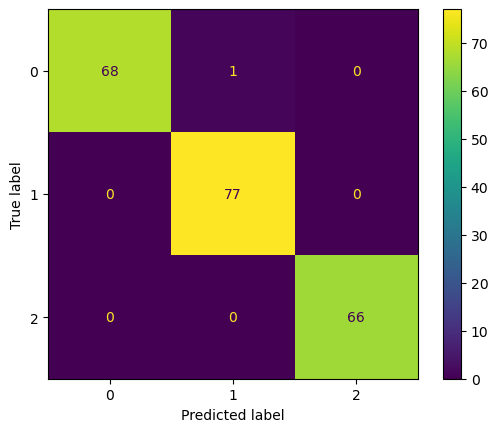

In [56]:
## Confusion Matrix of Best parameter 
cmp=ConfusionMatrixDisplay(cm_test)
cmp.plot()

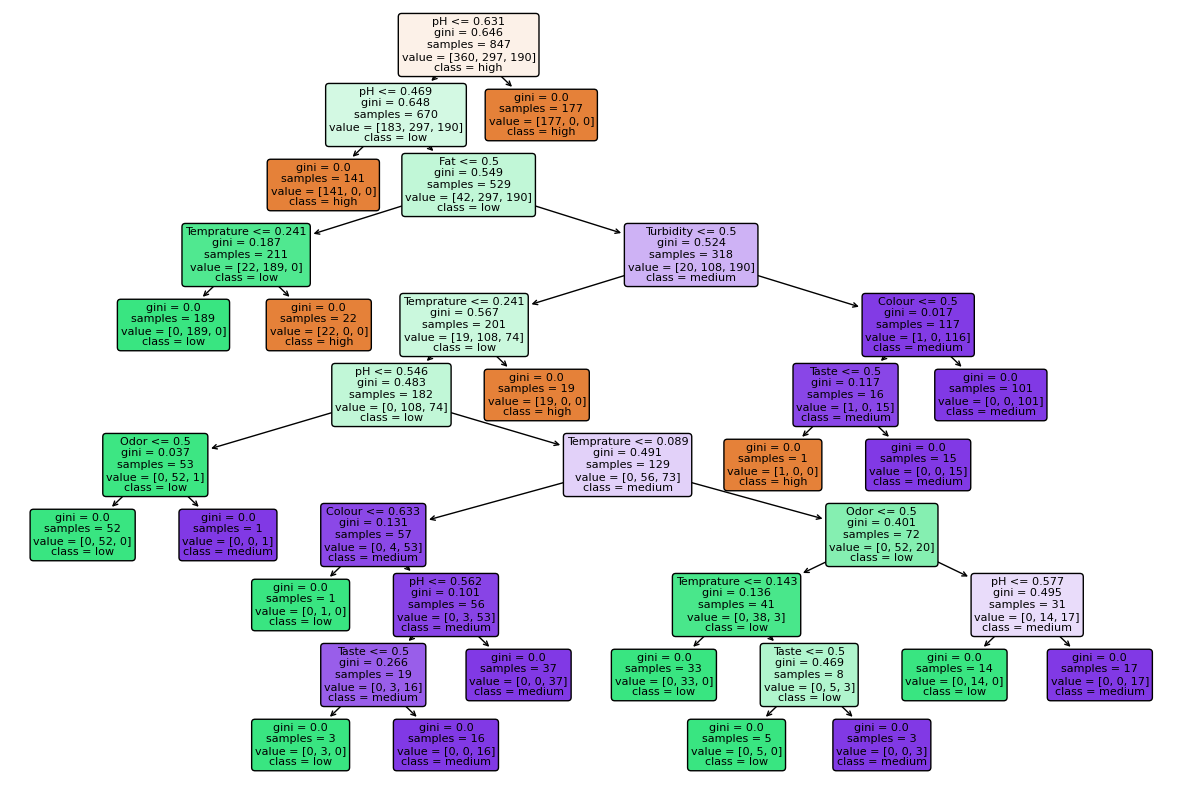

In [80]:
## Interpret Tree
a=raw_data["Grade"].copy()
a=a.unique().tolist()
plt.figure(figsize=(15, 10))
plot_tree(model_TREE, filled=True, feature_names=raw_x.columns.tolist(),class_names=a,rounded=True)
plt.savefig('decision_tree.png') 
plt.show()

## Random

In [58]:
#Random
## Build model
model_rf=RandomForestClassifier(max_depth=7, n_estimators=20)#max_depth=7, n_estimators=20
model_rf.fit(x_train,y_train)
y_pred_train=model_rf.predict(x_train)
y_pred_test=model_rf.predict(x_test)
print("The accurancy of train data is {}".format(accuracy_score(y_train,y_pred_train)))
print("The accurancy of test data is {}".format(accuracy_score(y_test,y_pred_test)))
print(np.mean(cross_val_score(model_rf,x_train,y_train,cv=10)))

The accurancy of train data is 1.0
The accurancy of test data is 0.9905660377358491
0.9988235294117647


In [60]:
param_grid = {
    'n_estimators': [ 15, 20, 25,30, 50, 100, 200, 300, 400, 500],
    'max_depth': [5, 7, 8,9]
}
Grf=GridSearchCV(model_rf,param_grid,cv=10)
Grf.fit(x_train,y_train)
print(Grf.best_estimator_,Grf.best_params_)

RandomForestClassifier(max_depth=7, n_estimators=25) {'max_depth': 7, 'n_estimators': 25}


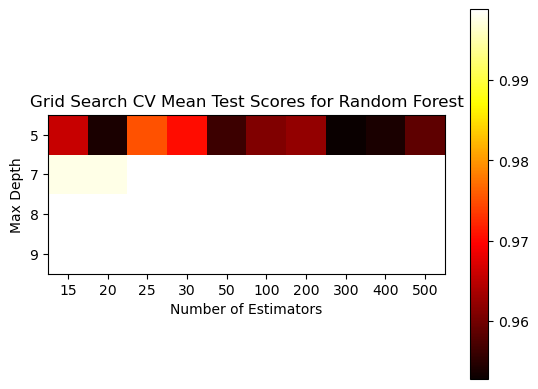

In [63]:
mean_scores=Grf.cv_results_['mean_test_score']
mean_scores = mean_scores.reshape(len(param_grid['max_depth']), len(param_grid['n_estimators']))
plt.imshow(mean_scores, interpolation='nearest', cmap=plt.cm.hot)
plt.title("Grid Search CV Mean Test Scores for Random Forest")
plt.xlabel("Number of Estimators")
plt.ylabel("Max Depth")
plt.colorbar()
plt.xticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.yticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'])
plt.grid(False)
plt.show()


The accurancy of train data is 1.0
The accurancy of test data is 0.9905660377358491
0.9988235294117647


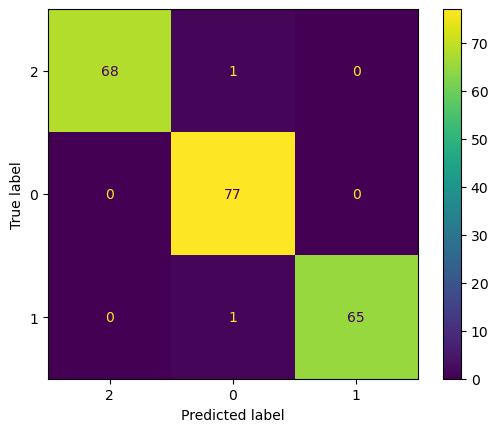

In [61]:
## Confusion Matrix of Best parameter 
model_rf=RandomForestClassifier(max_depth=7, n_estimators=25)
model_rf.fit(x_train,y_train)
y_pred_train=model_rf.predict(x_train)
y_pred_test=model_rf.predict(x_test)
cm_trian=confusion_matrix(y_train,y_pred_train)
cm_test=confusion_matrix(y_test,y_pred_test)
print("The accurancy of train data is {}".format(accuracy_score(y_train,y_pred_train)))
print("The accurancy of test data is {}".format(accuracy_score(y_test,y_pred_test)))
print(np.mean(cross_val_score(model_rf,x_train,y_train,cv=10)))
cmp=ConfusionMatrixDisplay(cm_test,display_labels=pd.Series(y_test).unique())
cmp.plot()

<Axes: >

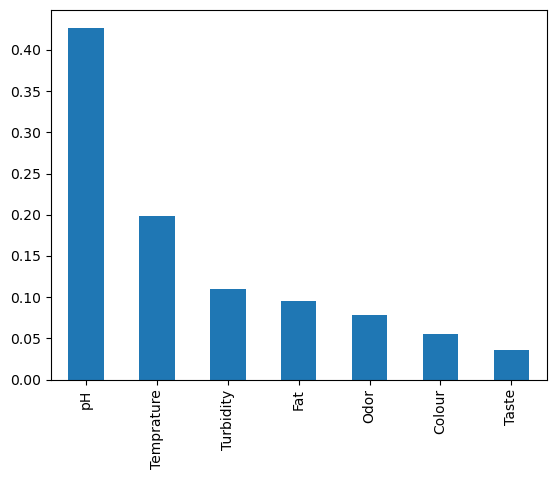

In [62]:
#importance
feature_importances = pd.Series(model_rf.feature_importances_, index=raw_x.columns).sort_values(ascending=False)
feature_importances.plot.bar()

## XGB

In [65]:
#default: colsample_bytree=0.4，learning_rate=0.3，max_depth=6，min_child_weight=1，n_estimators=None
model_XGB=XGBClassifier()
model_XGB.fit(x_train,y_train)
y_pred_train=model_XGB.predict(x_train)
y_pred_test=model_XGB.predict(x_test)
print("The accurancy of train data is {}".format(accuracy_score(y_train,y_pred_train)))
print("The accurancy of test data is {}".format(accuracy_score(y_test,y_pred_test)))

The accurancy of train data is 1.0
The accurancy of test data is 0.9905660377358491


In [157]:
print(cross_val_score(model_XGB,x_train,y_train,cv=10).mean())

0.9964425770308123


In [158]:
param_grid = {
    "n_estimators": [50,100,150,200,300], 
    "learning_rate": [0.05, 0.1, 0,2, 0.3], 
    "max_depth": [3,4,5,6,7], 
    "colsample_bytree": [0.4,0.6,0.8,1],
    "min_child_weight": [1,2,3,4] 
}
Gcv=GridSearchCV(model_XGB,param_grid,cv=10)
Gcv.fit(x_train,y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             param_grid={'colsample_bytree': [0.4, 0.6, 0.8, 1],
                         'learning_rate': [0.05, 0.1, 0, 2, 0.3],
                         'max_depth': [3, 4, 5, 6, 7],
                         'min_child_weight': [1, 2, 3, 4],
                         'n_estimators': [50, 100, 150, 200, 300]})

In [88]:
print(Gcv.best_estimator_,"\n",Gcv.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...) 
 {'colsample_bytree': 0.8, 'learning_rate': 2, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300}


The accurancy of train data is 1.0
The accurancy of test data is 0.9952830188679245
1.0


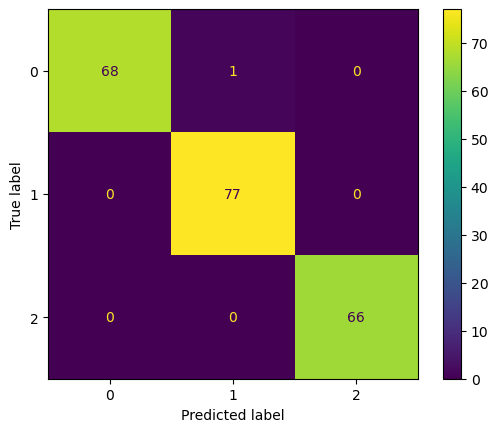

In [67]:
model_XGB=XGBClassifier(colsample_bytree=0.8, learning_rate=2, max_depth=4, min_child_weight= 2, n_estimators=300)
model_XGB.fit(x_train,y_train)
y_pred_train=model_XGB.predict(x_train)
y_pred_test=model_XGB.predict(x_test)
cm_trian=confusion_matrix(y_train,y_pred_train)
cm_test=confusion_matrix(y_test,y_pred_test)
print("The accurancy of train data is {}".format(accuracy_score(y_train,y_pred_train)))
print("The accurancy of test data is {}".format(accuracy_score(y_test,y_pred_test)))
print(cross_val_score(model_XGB,x_train,y_train,cv=10).mean())
cmp=ConfusionMatrixDisplay(cm_test)
cmp.plot()

In [2]:
model=['Logistic Regression', "LDA", "QDA", "KNN", "Decision Tree", "Random Forest","XGB"]
train_accuracy=[0.799, 0.727, 0.848, 1.00, 1.00, 1.00, 1.00]
test_accuracy=[0.736, 0.689, 0.807, 0.995, 0.991, 0.991, 0.995]
CV_accuracy=[0.754, 0.741, 0.818, 0.998, 0.994, 0.999,1 ]
all_models=pd.DataFrame({"Model":model, "Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy, "CV_accuracy": CV_accuracy})
all_models

,Model,Train Accuracy,Test Accuracy,CV_accuracy
0,Logistic Regression,0.799,0.736,0.754
1,LDA,0.727,0.689,0.741
2,QDA,0.848,0.807,0.818
3,KNN,1.000,0.995,0.998
4,Decision Tree,1.000,0.991,0.994
5,Random Forest,1.000,0.991,0.999
6,XGB,1.000,0.995,1.000


In [3]:
import altair as alt 
y_scale=alt.Scale(domain=[0.65, 1.0])
# train_plot=alt.Chart(all_models).mark_line(color='orange').encode(
#     x='Model:N',
#     y=alt.Y('Train Accuracy:Q', scale=y_scale)
# )
test_plot=alt.Chart(all_models).mark_line(color='Green').encode(
    x='Model:N',
    y=alt.Y('Test Accuracy:Q', scale=y_scale)
)
# cv_plot=alt.Chart(all_models).mark_line(color='red').encode(
#     x='Model:N',
#     y=alt.Y('CV_accuracy:Q', scale=y_scale)
# )
# layered_chart=alt.layer(train_plot, test_plot, cv_plot)
# layered_chart

In [4]:
test_plot

alt.Chart(...)

In [72]:
test_plot=alt.Chart(all_models).mark_bar(color='Green').encode(
    x='Model:N',
    y=alt.Y('Test Accuracy:Q')
)
test_plot

alt.Chart(...)